In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import os
import numpy as np
import csv
import gc

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
destination_dir = os.path.join('3a')
os.makedirs(destination_dir, exist_ok=True)

In [5]:
kc = 273.15

In [6]:
base_dir = os.path.join("data", "satellite_unique")

In [7]:
energy = pd.read_csv(os.path.join("data","energy_data.csv"))

energy = energy.drop(columns=["Unnamed: 0"])
energy.bbl = energy.bbl.astype(str)
energy.bin = energy.bin.astype(str)

energy.loc[:,"date"] = pd.to_datetime(energy.date)
energy.loc[:, "month_days"] = energy.date.dt.days_in_month
energy.loc[:,"month"] = energy.date.dt.month
energy.loc[:,"year"] = energy.date.dt.year
energy = energy.drop(columns=["date"])
energy

,bbl,heightroof,cnstrct_yr,groundelev,bin,area,Property Name,Month,Natural Gas Use (kBtu),Electricity Use (kBtu),month_days,month,year
0,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Jan-19,432243.3,66054.2,31,1,2019
1,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Feb-19,350454.9,73451.5,28,2,2019
2,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Mar-19,299657.7,82145.2,31,3,2019
3,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Apr-19,159527.6,68193.6,30,4,2019
4,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,May-19,81627.2,66175.2,31,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315367,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Aug-20,24153.1,85081.0,31,8,2020
315368,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Sep-20,23773.3,61960.8,30,9,2020
315369,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Oct-20,24696.1,51338.4,31,10,2020
315370,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Nov-20,27974.2,49512.1,30,11,2020


In [8]:
len((energy.bbl + energy.bin).unique())

9480

In [9]:
len(energy)

315372

In [10]:
sum(energy["Natural Gas Use  (kBtu)"] == 0)

4193

In [11]:
np.mean(energy.groupby(["bbl","bin"]).count()["heightroof"])

33.07215189873418

(array([6.300e+01, 7.360e+02, 1.104e+03, 7.367e+03, 8.000e+01, 4.100e+01,
        7.900e+01, 1.000e+00, 6.000e+00, 3.000e+00]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <BarContainer object of 10 artists>)

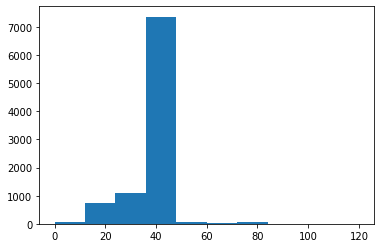

In [12]:
plt.hist(energy.groupby(["bbl","bin"]).count()["heightroof"])

In [13]:
len(energy)

315372

In [14]:
sum(energy.groupby(["bbl","bin"]).count()["heightroof"] < 25) / len(energy)

0.006034143804776581

In [15]:
def matching_preprocess(data_path):
    data = pd.read_csv(data_path)
    data.loc[:,"bbl"] = data.bbl.astype(str)
    data.loc[:,"bin"] = data.bin.astype(str)

    data.loc[:,"date"] = pd.to_datetime(data.date)
    data.loc[:,"month"] = data.date.dt.month
    data.loc[:,"year"] = data.date.dt.year
    data = data.drop(columns=["date"])
    data_combined = data.groupby(["bbl","bin","month","year"]).mean().reset_index()
    del data
    gc.collect()
    return data_combined.dropna()

In [16]:
viirs_path = os.path.join(base_dir,"viirs.csv")
viirs_combined = matching_preprocess(viirs_path)
viirs_combined.head(2)

,bbl,bin,month,year,avg_rad,cf_cvg
0,1000020001,1085792,1,2018,61.904870,12.025000
1,1000020001,1085792,1,2019,71.277628,10.878247


In [17]:
weather_path = os.path.join(base_dir,"era5.csv")
weather_combined = matching_preprocess(weather_path)
weather_combined.head(2)

,bbl,bin,month,year,mean_2m_air_temperature,minimum_2m_air_temperature,maximum_2m_air_temperature,dewpoint_2m_temperature,total_precipitation,surface_pressure,mean_sea_level_pressure,u_component_of_wind_10m,v_component_of_wind_10m
0,1000020001,1085792,1,2018,271.787140,255.525620,289.121735,266.019714,0.078149,101327.625,102253.250000,1.851955,-0.512473
1,1000020001,1085792,1,2019,272.800232,256.370728,286.953430,266.425201,0.110421,100897.375,101817.351562,1.854444,-0.679848


In [18]:
elevation_path = os.path.join(base_dir,"elevation.csv")
elevation = pd.read_csv(elevation_path)

elevation.loc[:,"bbl"] = elevation.bbl.astype(str)
elevation.loc[:,"bin"] = elevation.bin.astype(str)
elevation.dtypes

bbl           object
bin           object
elevation    float64
dtype: object

In [19]:
landsat_combined = matching_preprocess(os.path.join(base_dir, "landsat8.csv"))

landsat_combined.SR_B1 = landsat_combined.SR_B1 * 2.75e-05 - 0.2
landsat_combined.SR_B2 = landsat_combined.SR_B2 * 2.75e-05 - 0.2
landsat_combined.SR_B3 = landsat_combined.SR_B3 * 2.75e-05 - 0.2
landsat_combined.SR_B4 = landsat_combined.SR_B4 * 2.75e-05 - 0.2
landsat_combined.SR_B5 = landsat_combined.SR_B5 * 2.75e-05 - 0.2
landsat_combined.SR_B6 = landsat_combined.SR_B6 * 2.75e-05 - 0.2
landsat_combined.SR_B7 = landsat_combined.SR_B7 * 2.75e-05 - 0.2
landsat_combined.ST_B10 = landsat_combined.ST_B10 * 0.00341802 + 149
landsat_combined.ST_ATRAN = landsat_combined.ST_ATRAN * 0.0001
landsat_combined.ST_CDIST = landsat_combined.ST_CDIST * 0.01
landsat_combined.ST_DRAD = landsat_combined.ST_DRAD * 0.001
landsat_combined.ST_EMIS = landsat_combined.ST_EMIS * 0.0001

landsat_combined.ST_EMSD = landsat_combined.ST_EMSD * 0.0001
landsat_combined.ST_QA = landsat_combined.ST_QA * 0.01
landsat_combined.ST_TRAD = landsat_combined.ST_TRAD * 0.001
landsat_combined.ST_URAD = landsat_combined.ST_URAD * 0.001

In [20]:
landsat_combined.min(axis=0)

bbl         1000020001
bin            1000018
month                1
year              2018
ST_B10         258.677
ST_QA          1.89303
ST_ATRAN      0.428311
ST_CDIST          0.01
ST_DRAD          0.061
ST_EMIS       0.923549
ST_EMSD              0
ST_TRAD        4.58517
ST_URAD          0.093
SR_B1         -0.15744
SR_B2        -0.126984
SR_B3        -0.111922
SR_B4       -0.0924648
SR_B5       -0.0284143
SR_B6      -0.00678179
SR_B7         0.001795
NDVI        -0.0787865
dtype: object

In [21]:
def scale_terms(df, terms:list = [], scale: float = 0.0001):
    for term in terms:
        df[term] = df[term] * scale
        
    return df

In [22]:
sentinel_path = os.path.join(base_dir, "sentinel_1C.csv")
sentinel_1C_combined = matching_preprocess(sentinel_path)

sentinel_1C_combined = scale_terms(sentinel_1C_combined, ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'])
sentinel_1C_combined

,bbl,bin,month,year,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI
0,1000020001,1085792,1,2018,0.206575,0.182101,0.152030,0.151989,0.154958,0.156115,0.158149,0.151802,0.159224,0.081821,0.109474,0.090143,-0.027453
1,1000020001,1085792,1,2019,0.169070,0.141023,0.113475,0.107709,0.109233,0.108341,0.109687,0.105218,0.109719,0.059094,0.096297,0.077526,-0.039099
2,1000020001,1085792,1,2020,0.217367,0.184808,0.152600,0.148746,0.150144,0.150775,0.154511,0.142170,0.156438,0.077315,0.135997,0.122068,-0.030551
3,1000020001,1085792,2,2018,0.168231,0.140928,0.115948,0.111696,0.115014,0.114793,0.116510,0.113236,0.117113,0.064167,0.104551,0.084726,-0.022992
4,1000020001,1085792,2,2019,0.159160,0.133675,0.111602,0.105891,0.107395,0.107980,0.109938,0.106950,0.111988,0.059081,0.108102,0.088076,-0.029539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332995,5079910100,5088569,11,2019,0.176042,0.135193,0.107111,0.098392,0.102634,0.111850,0.116326,0.110680,0.119449,0.053913,0.113223,0.092822,0.047387
332996,5079910100,5088569,11,2020,0.191032,0.153812,0.125407,0.119038,0.121976,0.131297,0.137557,0.129873,0.142266,0.052534,0.140919,0.115521,0.036613
332997,5079910100,5088569,12,2018,0.184112,0.145180,0.111842,0.103211,0.103970,0.106305,0.108628,0.103289,0.109719,0.048527,0.109282,0.088408,-0.001464
332998,5079910100,5088569,12,2019,0.177848,0.139186,0.107845,0.102785,0.105885,0.109819,0.112503,0.107832,0.114300,0.059618,0.112455,0.095997,0.022847


In [23]:
sentinel_2A_path = os.path.join(base_dir, "sentinel_2A.csv")
sentinel_2A = matching_preprocess(sentinel_2A_path)

sentinel_2A_combined = scale_terms(sentinel_2A, ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'])
sentinel_2A_combined

,bbl,bin,month,year,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI
0,1000020001,1085792,1,2019,0.042800,0.063500,0.075100,0.090400,0.113500,0.152000,0.169700,0.199100,0.193000,0.192300,0.198000,0.143900,0.375475
3,1000020001,1085792,2,2020,0.046472,0.058208,0.072261,0.091092,0.115136,0.153650,0.169989,0.197157,0.193506,0.189531,0.193689,0.141944,0.370234
4,1000020001,1085792,3,2019,0.074300,0.085500,0.096500,0.118400,0.142400,0.178200,0.195600,0.224500,0.222600,0.223900,0.234900,0.173300,0.309420
5,1000020001,1085792,3,2020,0.054231,0.064769,0.079134,0.092433,0.120897,0.174196,0.194470,0.217592,0.216486,0.215631,0.194160,0.141424,0.406203
6,1000020001,1085792,4,2019,0.057830,0.062771,0.079812,0.092706,0.124351,0.180806,0.202611,0.224057,0.224201,0.227981,0.193425,0.139701,0.415110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231240,5079910100,5088569,8,2020,0.091293,0.054439,0.066410,0.059459,0.084192,0.144863,0.167292,0.165791,0.175925,0.215481,0.123736,0.088400,0.505795
231241,5079910100,5088569,9,2019,0.091392,0.039038,0.049288,0.041843,0.067295,0.126569,0.146474,0.153181,0.160336,0.203602,0.103477,0.062456,0.581626
231242,5079910100,5088569,9,2020,0.085910,0.038033,0.050128,0.043512,0.068240,0.124296,0.143624,0.147084,0.157509,0.200307,0.104836,0.064553,0.549979
231243,5079910100,5088569,10,2019,0.078150,0.079150,0.097150,0.103150,0.133700,0.189600,0.206850,0.220350,0.219300,0.221550,0.184650,0.141300,0.362135


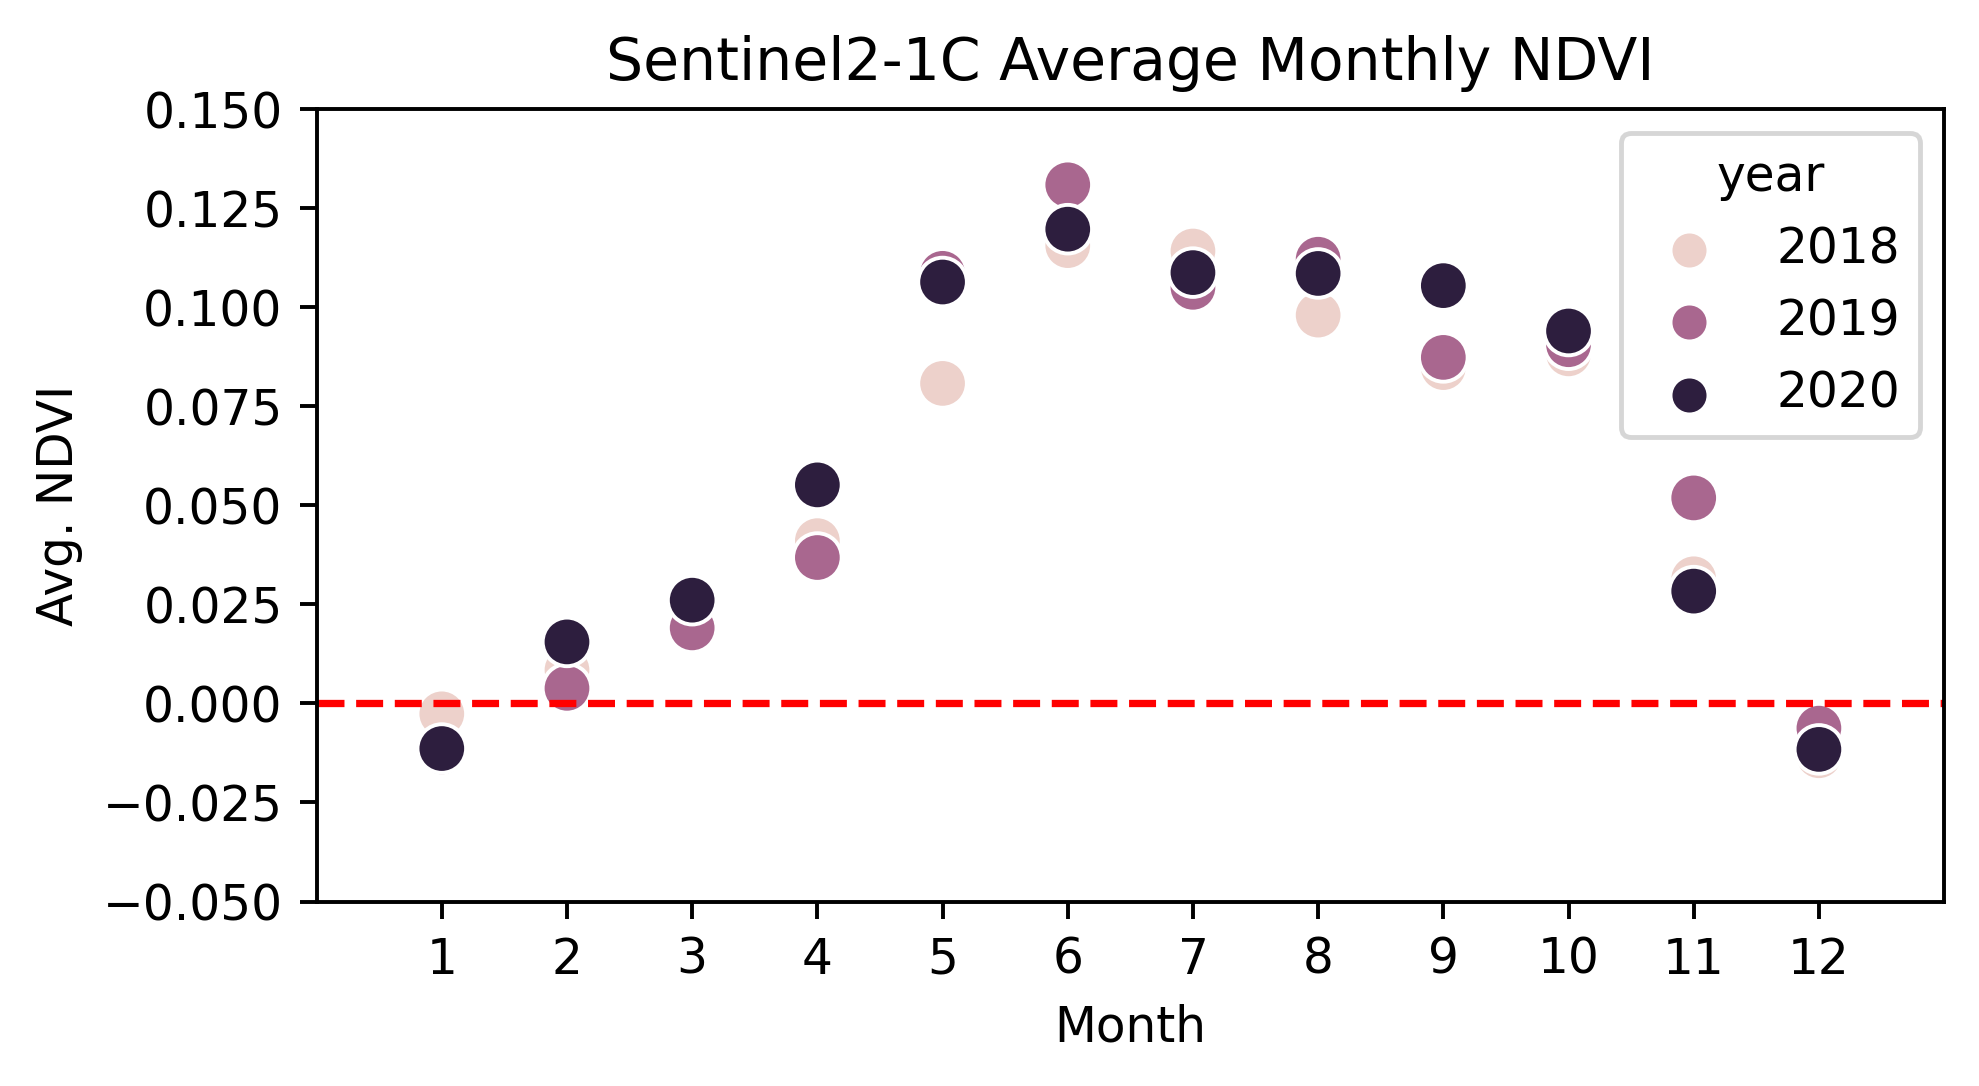

In [24]:
agg_stats = sentinel_1C_combined.groupby(['year','month']).agg(['count','mean']).reset_index()

plt.figure(figsize = (6,3), dpi=350)

term = "NDVI"
scatter = sns.scatterplot(data=agg_stats, x="month", y=(term,"mean"), hue="year", s=100, alpha=1)
scatter.axes.set_ylim(-0.05, 0.15)
scatter.axes.set_xlim(0, 13)

scatter.plot()

plt.axhline(y=0.0, color='r', linestyle='--')
plt.xticks(np.arange(1, 13, 1.0))

plt.title("Sentinel2-1C Average Monthly NDVI")
plt.ylabel("Avg. NDVI")
plt.xlabel("Month")
plt.savefig('sentinel2_ndvi.png', bbox_inches='tight')

plt.show()

In [25]:
landsat_combined["SR_B2"]

0         0.130683
1         0.079638
2         0.077639
3         0.074202
4         0.076151
            ...   
323744    0.060472
323745    0.061655
323746    0.059794
323747    0.087360
323749    0.062359
Name: SR_B2, Length: 270864, dtype: float64

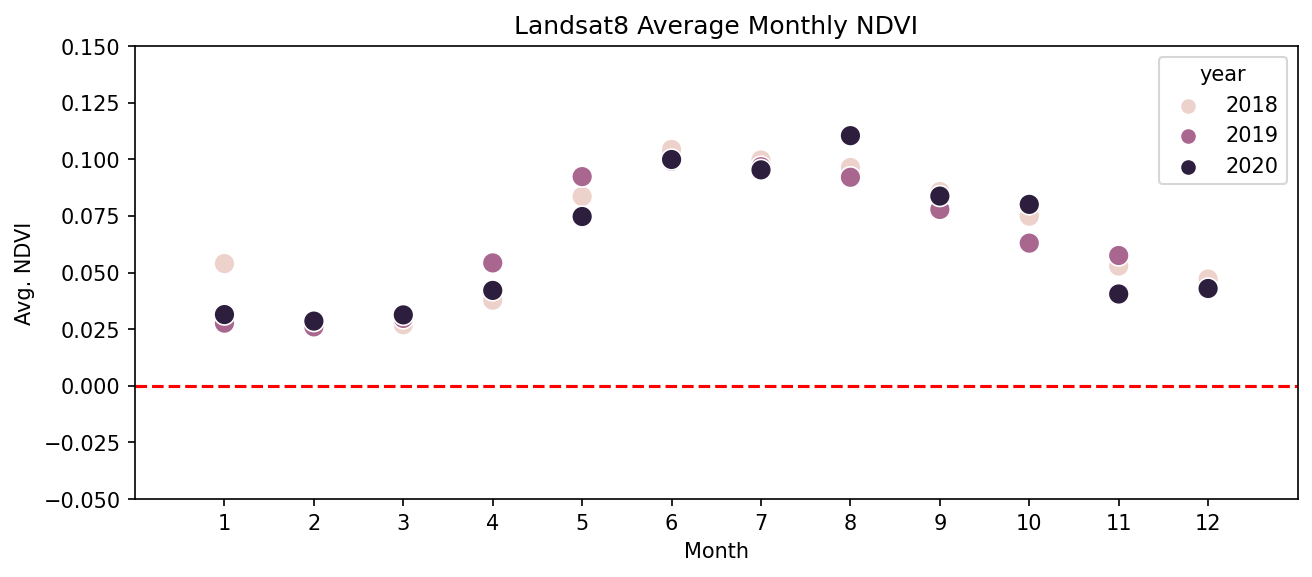

In [26]:
agg_stats = landsat_combined.groupby(['year','month']).agg(['count','mean']).reset_index()

plt.figure(figsize = (10,4), dpi=150)

term = "NDVI"
scatter = sns.scatterplot(data=agg_stats, x="month", y=(term,"mean"), hue="year", s=100, alpha=1)
scatter.axes.set_ylim(-0.05, 0.15)
scatter.axes.set_xlim(0, 13)

scatter.plot()

plt.axhline(y=0.0, color='r', linestyle='--')
plt.xticks(np.arange(1, 13, 1.0))

plt.title("Landsat8 Average Monthly NDVI")
plt.ylabel("Avg. NDVI")
plt.xlabel("Month")
plt.show()

In [27]:
# going to manage noaa a little bit uniquely to accomodate the rain coverage
noaa = pd.read_csv(os.path.join(base_dir, "noaa.csv")).fillna(0)

noaa.loc[:,"bbl"] = noaa.bbl.astype(str)
noaa.loc[:,"bin"] = noaa.bin.astype(str)

noaa.loc[:,"date"] = pd.to_datetime(noaa.date)
noaa.loc[:,"month"] = noaa.date.dt.month
noaa.loc[:,"year"] = noaa.date.dt.year
noaa = noaa.drop(columns=["date"])
noaa_combined = noaa.groupby(["bbl","bin","month","year"]).mean().reset_index().dropna()
del noaa
noaa_combined

,bbl,bin,month,year,HGT,PRES,TMP,DPT,UGRD,VGRD,SPFH,WDIR,WIND,GUST,VIS,TCDC,ACPC01
0,1000020001,1085792,1,2018,0.000000,102187.971920,-0.752693,-5.748498,2.501600,-0.945700,0.002855,217.130429,5.210147,8.464653,14621.653106,44.018406,0.059250
1,1000020001,1085792,1,2019,0.000000,101790.805467,0.656809,-5.740929,2.417289,-0.810971,0.002906,223.082648,4.851157,8.093431,14964.745774,50.599793,0.136282
2,1000020001,1085792,1,2020,0.000000,101975.080355,4.040029,-1.928043,2.312005,-0.430545,0.003690,231.069660,4.419123,7.300548,15007.037422,51.970697,0.038623
3,1000020001,1085792,2,2018,0.000000,102317.453572,5.013907,0.069095,1.105715,0.099785,0.004261,208.638069,4.213947,6.884900,13883.995350,60.852997,0.193923
4,1000020001,1085792,2,2019,0.000000,102063.921433,1.861292,-4.673826,1.848387,-0.765813,0.003021,211.486120,4.375121,7.372637,14479.624582,50.628436,0.108353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332995,5079910100,5088569,11,2019,6.106667,101765.456042,5.722993,-0.459502,1.620683,-0.486835,0.003897,240.360605,2.946581,6.709379,15462.084232,36.987392,0.036427
332996,5079910100,5088569,11,2020,6.106667,102070.939062,10.067892,4.586828,1.385371,0.298384,0.005650,228.810991,2.792163,5.421751,15108.357682,37.104609,0.000000
332997,5079910100,5088569,12,2018,6.106667,101875.202188,4.104888,-0.403066,0.972034,-0.425546,0.004005,210.071941,2.753453,6.232723,14527.844766,53.769598,0.134077
332998,5079910100,5088569,12,2019,6.106667,101768.323542,2.952342,-1.072517,1.352293,-0.661703,0.003744,211.398343,2.932848,6.598037,14005.868177,53.687797,0.136668


<AxesSubplot:>

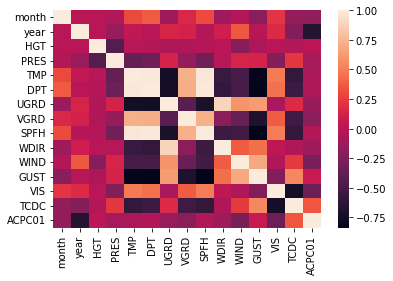

In [28]:
# calculate the correlation matrix
corr = noaa_combined.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [29]:
noaa_combined.TMP - 18.3333

0        -19.085993
1        -17.676491
2        -14.293271
3        -13.319393
4        -16.472008
            ...    
332995   -12.610307
332996    -8.265408
332997   -14.228412
332998   -15.380958
332999   -15.239686
Name: TMP, Length: 333000, dtype: float64

In [30]:
def degreedays(temperature):
    temperature_c = temperature # - kc # if units are in kelvin
    temperature_days = temperature_c - 18.3333 #65F to Celcius
    hdd = np.copy(temperature_days)
    hdd[hdd>0] = 0
    hdd = np.abs(hdd)
    cdd = np.copy(temperature_days)
    cdd[cdd<0] = 0
    cdd = np.abs(cdd)
    return hdd, cdd

In [31]:
noaa_combined["hdd"], noaa_combined["cdd"]  = degreedays(noaa_combined.TMP)

In [32]:
era5_combined = matching_preprocess(os.path.join(base_dir, "era5.csv"))

In [33]:
# era5_land_combined["2m_hdd"], era5_land_combined["2m_cdd"]  = degreedays(era5_land_combined.temperature_2m)
# era5_land_combined["skin_hdd"], era5_land_combined["skin_cdd"]  = degreedays(era5_land_combined.skin_temperature)
# era5_land_combined["soil_hdd"], era5_land_combined["soil_cdd"]  = degreedays(era5_land_combined.soil_temperature_level_1)
# era5_land_combined["dew_hdd"], era5_land_combined["dew_cdd"]  = degreedays(era5_land_combined.dewpoint_temperature_2m)
# era5_land_combined

In [49]:
footprints = gpd.read_file(os.path.join("data","nyc_footprints.geojson"))

In [50]:
council_regions = gpd.read_file(os.path.join("data","council_districts.geojson"))

In [51]:
footprint_councils = gpd.sjoin(footprints, council_regions[["coun_dist","geometry"]], how="left")
footprint_councils

,bbl,bin,geometry,index_right,coun_dist
0,3065220021,3170958,"POLYGON ((-73.96686 40.62606, -73.96662 40.626...",13.0,44
1,5060190091,5078368,"POLYGON ((-74.19517 40.55602, -74.19531 40.556...",31.0,51
2,3086910048,3245111,"POLYGON ((-73.96132 40.57751, -73.96065 40.577...",49.0,48
3,4075020005,4161096,"POLYGON ((-73.75440 40.75586, -73.75423 40.755...",4.0,23
4,5019900003,5122427,"POLYGON ((-74.14664 40.58870, -74.14661 40.589...",34.0,50
...,...,...,...,...,...
703582,4158030025,4301582,"POLYGON ((-73.76104 40.59577, -73.76105 40.595...",32.0,31
703583,3073970085,3201771,"POLYGON ((-73.95822 40.59420, -73.95758 40.594...",49.0,48
703584,4003990003,4004842,"POLYGON ((-73.93542 40.75231, -73.93474 40.753...",6.0,26
703585,3027420017,3425960,"POLYGON ((-73.94820 40.71640, -73.94897 40.716...",17.0,34


In [52]:
pluto = pd.read_csv(os.path.join("data","pluto_21v4.csv"))
pluto.bbl = pluto.bbl.astype(int).astype(str)
print(pluto.columns)

/home/thomas/miniconda3/envs/thermal/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (21,22,24,26,28,66) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010',
       'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct',
       'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict',
       'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3',
       'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3',
       'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext',
       'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland',
       'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2',
       'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar',
       'borocode', 'bbl', 'cond

In [53]:
# print(np.array(sorted(pluto.columns)).reshape((-1,1)))

In [54]:
# there are really only some columns I'm interested in incorporating, everything else might be a bit redundant
pluto_keep = ["bbl","assesstot","assessland","exempttot","bldgarea","yearbuilt"]
pluto_subsample = pluto.loc[:, pluto_keep]

In [55]:
len(pluto_subsample)

859032

In [56]:
pluto_subsample.isna().sum()

bbl             0
assesstot     392
assessland    392
exempttot     392
bldgarea      406
yearbuilt     392
dtype: int64

In [57]:
def add_latlong(footprints):
    foots = footprints.copy()
    centroid = foots.geometry.to_crs("EPSG:4326").centroid
    foots['latitude'] = centroid.y
    foots['longitude'] = centroid.x
    return pd.DataFrame(foots.drop(columns="geometry"))

In [58]:
collected_footprints = gpd.read_file(
    os.path.join("data","footprints.geojson")
)
footprints_ll = add_latlong(collected_footprints)

/home/thomas/miniconda3/envs/thermal/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
# this is the kind of ideal amount of data we could collect for the city
len(collected_footprints) * 12 * 3

333000

In [60]:
max_terms = len(collected_footprints) * 12 * 3
print("Max possible terms:\t{:,}\n".format(max_terms))

print("VIIRS length:\t\t{:.0%}".format(len(viirs_combined) / max_terms))
print("Sentinel-1C length:\t{:.0%}".format(len(sentinel_1C_combined) / max_terms))
print("Sentinel-2A length:\t{:.0%}".format(len(sentinel_2A_combined) / max_terms))
print("Landsat8 length:\t{:.0%}".format(len(landsat_combined) / max_terms))
print("NOAA length:\t\t{:.0%}".format(len(noaa_combined) / max_terms))
print("ERA5 length:\t\t{:.0%}".format(len(era5_combined) / max_terms))
print("Elevation length:\t{:.0%}".format(len(elevation)*3*12 / max_terms))

Max possible terms:	333,000

VIIRS length:		100%
Sentinel-1C length:	100%
Sentinel-2A length:	18%
Landsat8 length:	81%
NOAA length:		100%
ERA5 length:		83%
Elevation length:	100%


In [61]:
np.max(elevation.elevation)

107.99292417697008

In [62]:
footprints_ll.columns

Index(['bbl', 'bin', 'id', 'latitude', 'longitude'], dtype='object')

In [63]:
energy_cleaned = energy.merge(footprints_ll, on=["bbl","bin"]).dropna()
energy_cleaned = energy_cleaned.drop(columns=footprints_ll.columns.difference(['bbl','bin']))
energy_cleaned

,bbl,heightroof,cnstrct_yr,groundelev,bin,area,Property Name,Month,Natural Gas Use (kBtu),Electricity Use (kBtu),month_days,month,year
0,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Jan-19,432243.3,66054.2,31,1,2019
1,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Feb-19,350454.9,73451.5,28,2,2019
2,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Mar-19,299657.7,82145.2,31,3,2019
3,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Apr-19,159527.6,68193.6,30,4,2019
4,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,May-19,81627.2,66175.2,31,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301723,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Aug-20,24153.1,85081.0,31,8,2020
301724,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Sep-20,23773.3,61960.8,30,9,2020
301725,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Oct-20,24696.1,51338.4,31,10,2020
301726,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Nov-20,27974.2,49512.1,30,11,2020


In [64]:
def build_map(energy, new_data, on=["bbl"]):
    merged_data = energy.merge(new_data, on=on, how="left")

In [65]:
data_merge = energy.dropna()
len(data_merge)

273600

In [66]:
data_merge.merge(viirs_combined, on=["bbl","bin","month","year"], how='left')

,bbl,heightroof,cnstrct_yr,groundelev,bin,area,Property Name,Month,Natural Gas Use (kBtu),Electricity Use (kBtu),month_days,month,year,avg_rad,cf_cvg
0,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Jan-19,432243.3,66054.2,31,1,2019,109.235770,10.686719
1,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Feb-19,350454.9,73451.5,28,2,2019,120.049936,10.000000
2,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Mar-19,299657.7,82145.2,31,3,2019,96.557521,9.189844
3,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,Apr-19,159527.6,68193.6,30,4,2019,105.220094,7.000000
4,1007640007,73.151163,1930.0,22.0,1013712,679.313491,255 WEST 14TH STREET,May-19,81627.2,66175.2,31,5,2019,73.223737,5.346875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273595,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Aug-20,24153.1,85081.0,31,8,2020,28.790612,11.000000
273596,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Sep-20,23773.3,61960.8,30,9,2020,25.893059,11.443425
273597,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Oct-20,24696.1,51338.4,31,10,2020,23.112997,10.000000
273598,2048190015,71.040000,1940.0,98.0,2062829,628.002375,3915 Carpenter Avenue,Nov-20,27974.2,49512.1,30,11,2020,30.737431,14.000000


In [67]:
data_merge = energy.dropna()
data_merge = data_merge.merge(viirs_combined, on=["bbl","bin","month","year"], how='left')
# data_merge = data_merge.merge(landsat_combined, on=["bbl","bin","month","year"], how='left')
data_merge = data_merge.merge(sentinel_1C_combined, on=["bbl","bin","month","year"], how='left')
# data_merge = data_merge.merge(sentinel_2A_combined, on=["bbl","bin","month","year"], how='left')
data_merge = data_merge.merge(noaa_combined, on=["bbl","bin","month","year"], how='left')
# data_merge = data_merge.merge(era5_combined, on=["bbl","bin","month","year"], how='left')
data_merge = data_merge.merge(elevation, on=["bbl","bin"], how='left')
data_merge = data_merge.merge(pluto_subsample, on=["bbl"], how="left")

weels = data_merge
del data_merge; gc.collect()

0

In [68]:
print("Percent of Data Lost: {:.2f}%".format(100*(len(weels) - len(weels.dropna())) / len(weels)))

Percent of Data Lost: 3.98%


In [69]:
len(weels) - len(weels.dropna())

10891

In [70]:
weels[weels.isna()['B1']]

,bbl,heightroof,cnstrct_yr,groundelev,bin,area,Property Name,Month,Natural Gas Use (kBtu),Electricity Use (kBtu),...,TCDC,ACPC01,hdd,cdd,elevation,assesstot,assessland,exempttot,bldgarea,yearbuilt
469,1018480031,69.59,1927.0,32.0,1055849,718.049630,350 Manhattan Ave,Jan-18,590704.6,122519.3,...,NaN,NaN,NaN,NaN,NaN,4072950.0,303750.0,0.0,47730.0,1927.0
470,1018480031,69.59,1927.0,32.0,1055849,718.049630,350 Manhattan Ave,Feb-18,448716.7,93645.2,...,NaN,NaN,NaN,NaN,NaN,4072950.0,303750.0,0.0,47730.0,1927.0
471,1018480031,69.59,1927.0,32.0,1055849,718.049630,350 Manhattan Ave,Mar-18,468534.8,91211.8,...,NaN,NaN,NaN,NaN,NaN,4072950.0,303750.0,0.0,47730.0,1927.0
472,1018480031,69.59,1927.0,32.0,1055849,718.049630,350 Manhattan Ave,Apr-18,293182.7,76289.9,...,NaN,NaN,NaN,NaN,NaN,4072950.0,303750.0,0.0,47730.0,1927.0
473,1018480031,69.59,1927.0,32.0,1055849,718.049630,350 Manhattan Ave,May-18,141748.0,66204.0,...,NaN,NaN,NaN,NaN,NaN,4072950.0,303750.0,0.0,47730.0,1927.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272004,3021060024,69.87,1925.0,36.0,3059164,651.302481,25 Flatbush Ave,Aug-20,68400.0,334619.7,...,NaN,NaN,NaN,NaN,NaN,3339900.0,508500.0,0.0,30000.0,1925.0
272005,3021060024,69.87,1925.0,36.0,3059164,651.302481,25 Flatbush Ave,Sep-20,74500.0,233875.9,...,NaN,NaN,NaN,NaN,NaN,3339900.0,508500.0,0.0,30000.0,1925.0
272006,3021060024,69.87,1925.0,36.0,3059164,651.302481,25 Flatbush Ave,Oct-20,105100.0,229264.9,...,NaN,NaN,NaN,NaN,NaN,3339900.0,508500.0,0.0,30000.0,1925.0
272007,3021060024,69.87,1925.0,36.0,3059164,651.302481,25 Flatbush Ave,Nov-20,149100.0,196152.4,...,NaN,NaN,NaN,NaN,NaN,3339900.0,508500.0,0.0,30000.0,1925.0


In [71]:
percent_missing = pd.DataFrame((100 * weels.isna().sum() / len(weels)))
percent_missing

,0
bbl,0.000000
heightroof,0.000000
cnstrct_yr,0.000000
groundelev,0.000000
bin,0.000000
area,0.000000
Property Name,0.000000
Month,0.000000
Natural Gas Use (kBtu),0.000000
Electricity Use (kBtu),0.000000


In [72]:
# percent_missing.loc[["heightroof","B1","B2","TMP","assesstot","Natural Gas Use  (kBtu)"],:]

In [73]:
# report_missing = percent_missing.loc[["heightroof","B1","B2","TMP","assesstot","Natural Gas Use  (kBtu)"],:]\
#     .rename(index={"B1":"Sentinel-2 Level-1C", "B1_y": "Sentinel-2 Level-2A", "TMP":"NOAA RTMA","assesstot":"PLUTO","heightroof":"NYC Footprints", "Natural Gas Use  (kBtu)":"LL84 Monthly", "SR_B2":"Landsat8"})\
#     .rename(columns={0:"Percent Missing"})

# report_missing.style.format({'Percent Missing': "{:.2f}"})

In [74]:
na_weels = weels.isna().sum()/len(weels)
na_weels.index

Index(['bbl', 'heightroof', 'cnstrct_yr', 'groundelev', 'bin', 'area',
       'Property Name', 'Month', 'Natural Gas Use  (kBtu)',
       'Electricity Use  (kBtu)', 'month_days', 'month', 'year', 'avg_rad',
       'cf_cvg', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9',
       'B11', 'B12', 'NDVI', 'HGT', 'PRES', 'TMP', 'DPT', 'UGRD', 'VGRD',
       'SPFH', 'WDIR', 'WIND', 'GUST', 'VIS', 'TCDC', 'ACPC01', 'hdd', 'cdd',
       'elevation', 'assesstot', 'assessland', 'exempttot', 'bldgarea',
       'yearbuilt'],
      dtype='object')

In [75]:
# want to drop all of the data which doesn't give us enough information to go off
na_weels_dropping = na_weels[na_weels > 0.05].index
na_weels_dropping

Index([], dtype='object')

In [76]:
nadropped_weels = weels.drop(columns=list(na_weels_dropping))

In [77]:
full_weels = nadropped_weels.dropna()

kbtu_mwh = 3414.4259
full_weels.loc[:, "electricity_mwh"] = full_weels["Electricity Use  (kBtu)"] / kbtu_mwh
full_weels.loc[:, "gas_mwh"] = full_weels["Natural Gas Use  (kBtu)"] / kbtu_mwh
# full_weels.loc[:, "month"] = np.sin(full_weels.month * (2*np.pi / 12))

full_weels = full_weels.drop(columns=["Electricity Use  (kBtu)","Natural Gas Use  (kBtu)"])
# full_weels[['electricity_mwh','gas_mwh']]

/home/thomas/miniconda3/envs/thermal/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/thomas/miniconda3/envs/thermal/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### objective now is to tag the satellite data with the council of interest

In [78]:
full_weels.iloc[100]

bbl                          3074040001
heightroof                        62.76
cnstrct_yr                         1940
groundelev                           13
bin                             3202112
area                            954.349
Property Name      Eckstein: 1900 Ave W
Month                            May-19
month_days                           31
month                                 5
year                               2019
avg_rad                          24.674
cf_cvg                                9
B1                             0.209491
B2                             0.197334
B3                             0.188542
B4                             0.195808
B5                             0.203215
B6                             0.228466
B7                             0.242016
B8                             0.227243
B8A                             0.24986
B9                            0.0744998
B11                            0.257421
B12                            0.223009


In [79]:
footprint_councils

,bbl,bin,geometry,index_right,coun_dist
0,3065220021,3170958,"POLYGON ((-73.96686 40.62606, -73.96662 40.626...",13.0,44
1,5060190091,5078368,"POLYGON ((-74.19517 40.55602, -74.19531 40.556...",31.0,51
2,3086910048,3245111,"POLYGON ((-73.96132 40.57751, -73.96065 40.577...",49.0,48
3,4075020005,4161096,"POLYGON ((-73.75440 40.75586, -73.75423 40.755...",4.0,23
4,5019900003,5122427,"POLYGON ((-74.14664 40.58870, -74.14661 40.589...",34.0,50
...,...,...,...,...,...
703582,4158030025,4301582,"POLYGON ((-73.76104 40.59577, -73.76105 40.595...",32.0,31
703583,3073970085,3201771,"POLYGON ((-73.95822 40.59420, -73.95758 40.594...",49.0,48
703584,4003990003,4004842,"POLYGON ((-73.93542 40.75231, -73.93474 40.753...",6.0,26
703585,3027420017,3425960,"POLYGON ((-73.94820 40.71640, -73.94897 40.716...",17.0,34


In [80]:
weels_footprints = pd.merge(full_weels, footprint_councils, left_on=["bbl","bin"], right_on=["bbl","bin"])

In [81]:
weels_footprints.coun_dist.unique()

array(['3', '40', '14', '19', '45', '29', '41', '17', '15', '16', '4',
       '5', '6', '9', '2', '11', '1', '50', '25', '7', '48', '33', '13',
       '34', '18', '37', '20', '46', '44', '35', '42', '39', '22', '49',
       '36', '32', '27', '21', '43', '47', '28', '31', '26', '10', '24',
       '8', '23', '38', '30', '12', '51'], dtype=object)

In [82]:
# fig, ax = plt.subplots(figsize=(12,8), dpi= 500)

# weels_footprints.drop_duplicates(subset=["bbl","bin"]).heightroof.hist(bins=40, ax=ax)

<AxesSubplot:>

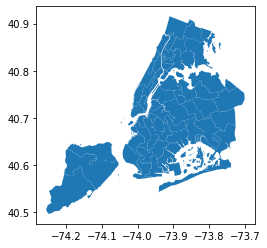

In [83]:
council_filterlist = [ x in weels_footprints.coun_dist.unique() for x in council_regions.coun_dist ]
council_regions.loc[council_filterlist].plot()

In [84]:
# pluto = pd.read_csv("pluto_21v4.csv")
# pluto.columns

In [85]:
# print(pluto.dtypes.to_string())

In [86]:
filtered_weels_footprints = weels_footprints #[weels_footprints.heightroof < 300]

In [87]:
weels_council = filtered_weels_footprints.loc[filtered_weels_footprints["coun_dist"]=="3"]
weels_noncouncil = filtered_weels_footprints.loc[~(filtered_weels_footprints['coun_dist']=="3")]

In [88]:
len(weels_council.coun_dist)

11503

In [89]:
weels_noncouncil.columns

Index(['bbl', 'heightroof', 'cnstrct_yr', 'groundelev', 'bin', 'area',
       'Property Name', 'Month', 'month_days', 'month', 'year', 'avg_rad',
       'cf_cvg', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9',
       'B11', 'B12', 'NDVI', 'HGT', 'PRES', 'TMP', 'DPT', 'UGRD', 'VGRD',
       'SPFH', 'WDIR', 'WIND', 'GUST', 'VIS', 'TCDC', 'ACPC01', 'hdd', 'cdd',
       'elevation', 'assesstot', 'assessland', 'exempttot', 'bldgarea',
       'yearbuilt', 'electricity_mwh', 'gas_mwh', 'geometry', 'index_right',
       'coun_dist'],
      dtype='object')

In [90]:
# now I'm going to collect all of the buildings and split them into train and validate, to avoid bias
weels_buildings = weels_noncouncil[["bbl","bin"]].drop_duplicates()
weels_buildings.head(4)

,bbl,bin
24,3050830044,3116615
60,2033180015,2017499
96,3050580057,3116089
132,4045910129,4104169


In [94]:
from sklearn.model_selection import train_test_split
train_buildings, validate_buildings = train_test_split(weels_noncouncil, test_size=0.20, random_state=42)

In [95]:
train_buildings

,bbl,heightroof,cnstrct_yr,groundelev,bin,area,Property Name,Month,month_days,month,...,assesstot,assessland,exempttot,bldgarea,yearbuilt,electricity_mwh,gas_mwh,geometry,index_right,coun_dist
161014,2031620011,65.318402,1928.0,122.0,2013757,849.054092,2188 Creston Ave.,Oct-19,31,10,...,1552950.0,58500.0,0.0,45120.0,1928.0,21.892787,8.350071,"POLYGON ((-73.90250 40.85480, -73.90281 40.854...",41.0,14
215288,1021240017,195.000000,2001.0,167.0,1062989,1583.652347,Irving Cancer Research Center,Mar-19,31,3,...,47146050.0,1350000.0,47146050.0,286481.0,2001.0,1054.960923,1992.008261,"POLYGON ((-73.93970 40.83965, -73.93947 40.840...",25.0,10
160951,2033280108,63.450000,1959.0,173.0,2017810,1073.847949,3555 Bainbridge Avenue,Jul-20,31,7,...,1486800.0,349200.0,0.0,66300.0,1959.0,32.957312,28.658786,"POLYGON ((-73.87838 40.88271, -73.87824 40.882...",40.0,11
199502,4001840037,64.220000,1931.0,78.0,4002386,1146.618219,Venture: 41-42 42 St,Mar-19,31,3,...,2965950.0,227700.0,62207.0,74664.0,1931.0,19.788129,176.829874,"POLYGON ((-73.92186 40.74691, -73.92189 40.746...",6.0,26
150387,3052410031,64.740000,1954.0,23.0,3121398,2444.611587,1111 OCEAN AVENUE TENANTS CORP,May-19,31,5,...,3420000.0,397800.0,2460.0,157493.0,1954.0,36.502857,107.631564,"POLYGON ((-73.95771 40.63367, -73.95786 40.634...",14.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125921,3046300001,45.280000,1926.0,30.0,3100597,710.926926,1068 Winthrop Street,Mar-18,31,3,...,984150.0,67500.0,0.0,30560.0,1926.0,16.045743,121.792363,"POLYGON ((-73.92415 40.66118, -73.92387 40.661...",10.0,41
108751,3051620001,63.640000,1928.0,31.0,3118794,537.388778,DRENIS ASSOCIATES LLC (1902 Cortelyou RD),Oct-18,31,10,...,1066950.0,250200.0,0.0,35354.0,1928.0,10.939643,54.416176,"POLYGON ((-73.96069 40.64260, -73.96072 40.642...",3.0,40
138516,4049600001,57.170000,1862.0,20.0,4112147,641.714719,CIG - 4112147 - Flushing Town Hall (LL84),Oct-20,31,10,...,1571400.0,886500.0,1571400.0,25200.0,1862.0,7.440402,19.867469,"POLYGON ((-73.83000 40.76410, -73.82989 40.763...",47.0,20
154124,1008800080,152.210000,1912.0,31.0,1018086,336.891949,11825 Owners Corp,Dec-18,31,12,...,4371300.0,904500.0,0.0,49020.0,1912.0,17.358643,113.192001,"POLYGON ((-73.98428 40.74093, -73.98446 40.740...",19.0,2


In [96]:
train_features = pd.merge(train_buildings, weels_buildings, left_on=["bbl","bin"], right_on=["bbl","bin"])

In [97]:
len(train_features)

167726

In [98]:
train_features.columns

Index(['bbl', 'heightroof', 'cnstrct_yr', 'groundelev', 'bin', 'area',
       'Property Name', 'Month', 'month_days', 'month', 'year', 'avg_rad',
       'cf_cvg', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9',
       'B11', 'B12', 'NDVI', 'HGT', 'PRES', 'TMP', 'DPT', 'UGRD', 'VGRD',
       'SPFH', 'WDIR', 'WIND', 'GUST', 'VIS', 'TCDC', 'ACPC01', 'hdd', 'cdd',
       'elevation', 'assesstot', 'assessland', 'exempttot', 'bldgarea',
       'yearbuilt', 'electricity_mwh', 'gas_mwh', 'geometry', 'index_right',
       'coun_dist'],
      dtype='object')

In [99]:
validate_features = pd.merge(validate_buildings, weels_buildings, left_on=["bbl","bin"], right_on=["bbl","bin"])

In [100]:
validate_features

,bbl,heightroof,cnstrct_yr,groundelev,bin,area,Property Name,Month,month_days,month,...,assesstot,assessland,exempttot,bldgarea,yearbuilt,electricity_mwh,gas_mwh,geometry,index_right,coun_dist
0,5002380046,36.900000,1971.0,39.0,5089736,1116.872723,Richmond: 325 Jewett Ave.,Apr-20,30,4,...,654300.0,382950.0,0.0,25470.0,1971.0,9.846546,73.863076,"POLYGON ((-74.12943 40.62887, -74.13013 40.629...",15.0,49
1,5002380046,36.900000,1971.0,39.0,5089736,1116.872723,Richmond: 325 Jewett Ave.,Aug-18,31,8,...,654300.0,382950.0,0.0,25470.0,1971.0,18.216503,22.522088,"POLYGON ((-74.12943 40.62887, -74.13013 40.629...",15.0,49
2,5002380046,36.900000,1971.0,39.0,5089736,1116.872723,Richmond: 325 Jewett Ave.,Aug-19,31,8,...,654300.0,382950.0,0.0,25470.0,1971.0,14.556415,16.752450,"POLYGON ((-74.12943 40.62887, -74.13013 40.629...",15.0,49
3,5002380046,36.900000,1971.0,39.0,5089736,1116.872723,Richmond: 325 Jewett Ave.,Dec-18,31,12,...,654300.0,382950.0,0.0,25470.0,1971.0,9.986628,96.473056,"POLYGON ((-74.12943 40.62887, -74.13013 40.629...",15.0,49
4,5002380046,36.900000,1971.0,39.0,5089736,1116.872723,Richmond: 325 Jewett Ave.,Nov-19,30,11,...,654300.0,382950.0,0.0,25470.0,1971.0,9.297786,72.369414,"POLYGON ((-74.12943 40.62887, -74.13013 40.629...",15.0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41927,2038380118,19.300000,1973.0,10.0,2097347,3897.303679,1150 Commerce Ave,Aug-20,31,8,...,1574100.0,338400.0,338400.0,37145.0,1973.0,46.731106,0.004891,"POLYGON ((-73.84043 40.83328, -73.84117 40.832...",37.0,13
41928,2058731042,62.160000,1958.0,77.0,2085341,1141.969526,6601 Broadway-Bronx,Jan-19,31,1,...,2563650.0,179550.0,79558.0,92640.0,1958.0,21.980943,262.945580,"POLYGON ((-73.89678 40.90884, -73.89678 40.908...",40.0,11
41929,1021450044,57.977376,1910.0,190.0,1063571,391.198969,WH - 655 W 177th Street,Oct-20,31,10,...,801450.0,85500.0,0.0,23425.0,1910.0,8.324298,53.240634,"POLYGON ((-73.93660 40.84786, -73.93691 40.847...",25.0,10
41930,2029180016,37.380000,1920.0,52.0,2009577,1286.976790,478 EAST TREMONT AVENUE,Nov-20,30,11,...,1495800.0,307350.0,0.0,27524.0,1920.0,17.519724,22.521297,"POLYGON ((-73.89775 40.84576, -73.89851 40.845...",39.0,15


In [101]:
test_features = weels_council

In [102]:
# gpd.GeoDataFrame(train_features).to_file(os.path.join(destination_dir, 'training.geojson'), driver='GeoJSON')
# gpd.GeoDataFrame(validate_features).to_file(os.path.join(destination_dir, 'validating.geojson'), driver='GeoJSON')
# gpd.GeoDataFrame(test_features).to_file(os.path.join(destination_dir, 'testing.geojson'), driver='GeoJSON')

In [103]:
# also want to save CSVs which will probably be a bit more comfortable to work with

In [104]:
train_features.drop(columns=["geometry"]).to_csv(os.path.join(destination_dir, "training.csv"))

In [105]:
validate_features.drop(columns=["geometry"]).to_csv(os.path.join(destination_dir, "validating.csv"))

In [106]:
test_features.drop(columns=["geometry"]).to_csv(os.path.join(destination_dir, "testing.csv"))